# SCALES low-res SED example - PHYSICAL OPTICS LENSLET PSFS

This notebook runs through all the steps for generating a raw SCALES image using either:

(1) a target spectrum in erg/s/cm^2/um + a PSF
OR
(2) a model datacube with fluxes in erg/s/cm^2/um

You don't need to change any of the configuration stuff at the beginning if you don't want to. There are comments that describe some parameters that you might be interested in adjusting.

Right now we just have the 2-5 um mode enabled. In the future you'll be able to switch to other low-res modes. To do that all you have to do is change arg_spaxel['min_wavelength'] and arg_spaxel['max_wavelength'] at the bottom of the "Configure SCALES Mode" section.

This example just uses PHOENIX models to set up simple stellar targets as "Target" objects. It then uses PHOENIX models to make an example model datacube that you can feed to the simulator. You can replace that with whatever scene you like, as long as the dimensions match the number of spaxels in each dimension (108 by 108). 

In the end it does a simple aperture extraction to generate a datacube. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [2]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [3]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [4]:
config.read('scales_h2rg.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

Adjust minimum and maximum wavelength if we want to

In [5]:
arg_spaxel['min_wavelength'] = 2.0 #minimum wavelength in microns
arg_spaxel['max_wavelength'] = 5.2 #maximum wavelength in microns

## Read in Keck pupil

In [6]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

In [7]:
screen = PhaseScreen(pupil=pupil, L0=10)
screen.sr_factor = screen.set_strehl(.8, 500e-9)
screen1 = screen.get_res()
#screen1 = np.zeros(screen1.shape)

## Use pupil and residual phase to generate cube of Keck PSFs

In [8]:
nspax = arg_spaxel['no_spaxel']
#nlam = lens.trace.shape[0]
nlam = 341

keck_cube = np.zeros((nlam, nspax, nspax))
mag1 = magn(arg_spaxel['min_wavelength'])
mag2 = magn(arg_spaxel['max_wavelength'])

psf_file = 'keck_psf_cube_'+str(arg_spaxel['min_wavelength'])+'_'+str(arg_spaxel['max_wavelength'])+'_n'+str(nlam)+'.fits'
if os.path.isfile(psf_file)==False:
    for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
        W = DFT_matrix(1600, mag)
        A = pupil.pupil * np.exp(1.j * screen1)
        out = abs(W.dot(A).dot(W))**2
        out /= np.sum(out, axis=(0,1))
        keck_cube[i] = frebin(out, (108, 108))
    fits.writeto(psf_file,np.array(keck_cube),clobber=True)
else: keck_cube = pyfits.getdata(psf_file)

## Define some observational parameters

-Reads in sky transmission and emission models provided by Gemini for MK site: https://www.gemini.edu/observing/telescopes-and-sites/sites#IRSky

-Reads in atmospheric dispersion data based on relative humidity, temperature, pressure, and airmass

-Instrument transmission & emission includes SCALES + AO emissivity

-Default QE is 70%

-For now set up perfect filter with tophat from lmin to lmax

-Define single frame integration time in seconds

In [9]:
vapor = 1 #PWV in mm
airmass = 1 
skybg = SkyBG(vapor,airmass)
skytrans = SkyTrans(vapor,airmass)
atmodisp = AtmoDispersion(90,20,600)
inst_emissivities = [.08]*3 + [.01]*8
inst_temps = [273*u.K]*11
inst = InstTransEm(inst_emissivities, inst_temps)
qe = QE()
filt = Filter(lmin=arg_spaxel['min_wavelength'],lmax=arg_spaxel['max_wavelength'])
dit = 1 ###integration time in seconds

## Setting up a target for scalessim

In [10]:
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 100.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)

####set this up as a Target
targ = Target(wav,I_lam)

## Define simple trace extraction

In [11]:
 def extract_using_trace(frame,llens):
    poss = llens.args['spaxel_size_px'] * np.arange(fp.num_spaxel)
    cinds = np.where(np.abs(fp.lam.value - llens.lmin)<1.0e-6)[0][0]
    cinde = np.where(np.abs(fp.lam.value - llens.lmax)<1.0e-6)[0][0]
    dx = llens.xx[cinds]
    dy = llens.yy[cinds]
    ii = 54
    jj = 54
    npx = llens.trace[0].shape[1]/2
    npy = llens.trace[0].shape[0]/2
    xloc=(npx+dx)
    yloc=(npy+dy)
    sdx = poss[ii]-xloc
    sdy = poss[jj]-yloc
    imy = int(sdy)
    imx = int(sdx)
    dimy = sdy - imy
    dimx = sdx - imx
    lamsx = fp.lam[cinds:cinde+1]
    toextr=llens.trace.copy()[cinds:cinde+1]
    specout = []
    for ll in range(len(toextr)):
        tinp = toextr[ll]
        toadd = np.zeros([tinp.shape[0]+2,tinp.shape[1]+2])
        dxt = len(toadd)
        dyt = len(toadd[0])
        toadd[1:1+len(tinp),1:1+len(tinp[0])] = np.array(tinp)
        toadd = shift(toadd,(dimy,dimx),order=1,prefilter=False)
        ones = np.zeros(toadd.shape)
        ones[np.where(toadd > np.max(toadd)*0.25)] = 1.0        
        specex = np.sum(frame[imy:imy+dyt,imx:imx+dxt]*toadd)
        specout.append([lamsx[ll].value,specex])
    return np.array(specout)

# Raw frame generation with default rotation angle 

## Set up lenslet traces

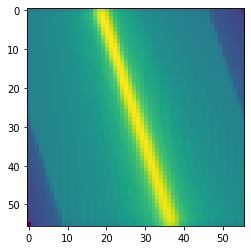

In [12]:
lens = Lenslet(arg_spaxel)
lens.get_shifts()
lens.make_trace(phys=False, verbose=True)

In [13]:
####organize all these and pass to focal_plane 
args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
fp = FocalPlane(args_new)

## Generate raw SCALES frame using target + PSF

making full raw image


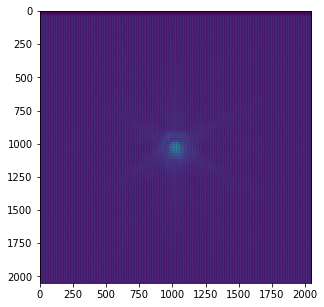

In [14]:
raw, bg_star_truth = fp.get_fp(dit*u.s,targ,return_full=True,PSF=keck_cube)
rawfile = 'raw_frame_targ.fits'
pyfits.writeto(rawfile,np.array(raw),clobber=True)

f = plt.figure(figsize=(5,5))
plt.imshow(raw**0.25)
plt.show()

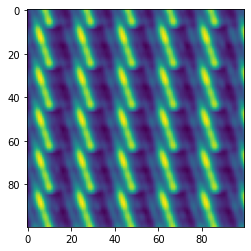

In [15]:
plt.imshow(raw[500:600,500:600]**0.1)

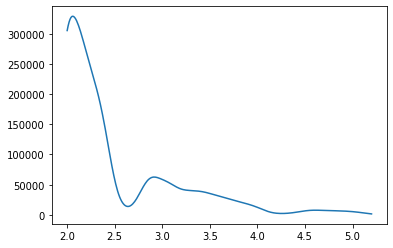

In [16]:
cinds = np.where(np.abs(fp.lam.value - lens.lmin)<1.0e-6)[0][0]
cinde = np.where(np.abs(fp.lam.value - lens.lmax)<1.0e-6)[0][0]
specout = extract_using_trace(raw,lens)
plt.plot(specout[:,0],specout[:,1])
plt.show()

# Test raw frame generation with different rotation angle 

## Test trace generation with different rotation angle 

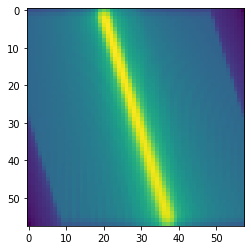

In [17]:
ROT = 17.5
lens_rot = Lenslet(arg_spaxel)
lens_rot.get_shifts(rot = ROT)
lens_rot.make_trace(phys=False, verbose=True)

In [18]:
####organize all these and pass to focal_plane 
args_new = {'Lenslet_object':lens_rot,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
fp = FocalPlane(args_new)

## Generate raw SCALES frame using target + PSF

In [ ]:
raw_rot, bg_star_truth = fp.get_fp(dit*u.s,targ,return_full=True,PSF=keck_cube)
rawfile = 'raw_frame_rot'+str(ROT)+'.fits'
pyfits.writeto(rawfile,np.array(raw),clobber=True)

f = plt.figure(figsize=(5,5))
plt.imshow(raw_rot**0.25)
plt.show()

making full raw image


In [ ]:
plt.imshow(raw_rot[500:600,500:600]**0.1)

In [ ]:
cinds = np.where(np.abs(fp.lam.value - lens_rot.lmin)<1.0e-6)[0][0]
cinde = np.where(np.abs(fp.lam.value - lens_rot.lmax)<1.0e-6)[0][0]
specout_rot = extract_using_trace(raw_rot,lens_rot)
plt.plot(specout_rot[:,0],specout_rot[:,1])
plt.show()

In [ ]:
plt.plot(specout_rot[:,0],specout_rot[:,1]/specout[:,1])